## Instacart Market Basket Analysis - Final Analysis-test

Instacart is a technology company providing a same day delivery grocery service to users across the U.S and Canada. Users place their grocery orders through the Instacart app and a personal Instacart shopper delivers the order to their home.

Instacart made public an anonymized data of 3 million Instacart shoppers presenting researchers with the challenge of predicting which previously purchased products will be in the user’s next order. 

This report includes the following processes:

- the selection of Instacart users <br>
- data extraction <br>
- features model creation
- splitting of data into train and test data <br>
- 3 Machine Learning models <br> 
- testing and prediction <br>

Files downloaded from Kaggle website as part of the Kaggle Instacart Market Basket Analysis competition:
- orders.csv <br>
- order_products__prior.csv <br>
- order_products__train.csv <br>
- products.csv <br>
- aisles.csv <br>
- departments.csv <br>

Data source: https://www.kaggle.com/c/instacart-market-basket-analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Reading csv files into Pandas DataFrames

filename_orders_file = 'files/orders.csv'
filename_products_prior = 'files/order_products__prior.csv'
filename_products_train= 'files/order_products__train.csv'
filename_products = 'files/products.csv'
filename_aisles = 'files/aisles.csv'
filename_departments = 'files/departments.csv'

orders = pd.read_csv(filename_orders_file , dtype={
            'order_id': np.int32,
            'user_id': np.int32,
            'eval_set': 'category',
            'order_number': np.int16,
            'order_dow': np.int8,
            'order_hour_of_day': np.int8,
            'days_since_prior_order': np.float32})
order_products_prior = pd.read_csv(filename_products_prior, dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})
order_products_train= pd.read_csv(filename_products_train, dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})
products = pd.read_csv(filename_products, dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'aisle_id': np.uint8,
            'department_id': np.uint8})
aisles = pd.read_csv(filename_aisles)
departments = pd.read_csv(filename_departments)

# Sample selection

In [10]:
# Orders with train eval_set are selected
orders_train = orders.loc[orders['eval_set'] == 'train']

In [11]:
# A random selection of users is made from orders
unique_orders = pd.DataFrame(orders_train['user_id'].unique(), columns=['user_id'])
selected_users = unique_orders.sample(frac = 0.385)
print("Data sample has",len(selected_users), "unique users")

Data sample has 50515 unique users


In [12]:
#train orders 
selected_users = orders['user_id'].isin(selected_users['user_id'])
orders_tr = orders[selected_users]
orders_tr.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
11,2168274,2,prior,1,2,11,NaN
12,1501582,2,prior,2,5,10,10.0


In [13]:
# order_products_prior is merged with selected train orders
priors = pd.merge(orders_tr,order_products_prior,  on='order_id')
priors.head(2)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2168274,2,prior,1,2,11,NaN,32792,1,0
1,2168274,2,prior,1,2,11,NaN,47766,2,0


# Product features

In [14]:
# product information is added to users and orders selected. d_X dataframe is created and will be added features.
df = pd.merge(priors.drop('eval_set',axis=1), products.drop('product_name', axis=1), on='product_id')
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id
0,2168274,2,1,2,11,NaN,32792,1,0,23,19
1,1901567,2,3,1,10,3.0,32792,2,1,23,19


In [15]:
# accounting for days_since_prior_order column NaN
df['days_since_prior_order'].fillna(0, inplace = True)

In [16]:
#products reordered ratio
reorder_ratio = pd.DataFrame()
reorder_ratio['number_orders'] = df.groupby('product_id').size().astype(np.int16)
reorder_ratio['number_reorders'] = df.groupby('product_id')['reordered'].apply(lambda x: x[x == 1].count()).astype(np.int16)
reorder_ratio['reordered_ratio'] = reorder_ratio['number_reorders']/reorder_ratio['number_orders']
reorder_ratio.head(2)

,number_orders,number_reorders,reordered_ratio
product_id,,,
1,405,250,0.617284
2,25,5,0.200000


In [17]:
avg_order_time = pd.DataFrame()
avg_order_time['avg_days_since_prior_order'] = df.groupby('product_id')['days_since_prior_order'].mean()
avg_order_time.head(2)

,avg_days_since_prior_order
product_id,
1,10.562963
2,7.960000


In [18]:
products_stats = pd.merge(reorder_ratio, avg_order_time, on='product_id')
df = pd.merge(df, products_stats, on='product_id')

# User behavior features

In [19]:
avg_time_orders = pd.DataFrame()
avg_time_orders['user_average_days_between_orders'] = orders_tr.groupby('user_id')['days_since_prior_order'].mean()
avg_time_orders['user_number_orders'] = orders_tr.groupby('user_id').size().astype(np.int16)
avg_time_orders.head(2)

,user_average_days_between_orders,user_number_orders
user_id,,
2,16.285715,15
8,23.333334,4


In [20]:
user_products = pd.DataFrame()
user_products['user_total_items'] = df.groupby('user_id').size().astype(np.int16)
user_products['all_products'] =  df.groupby('user_id')['product_id'].apply(set)
user_products['user_total_distinct_items'] = (user_products.all_products.map(len)).astype(np.int16)
user_products.head(2)

,user_total_items,all_products,user_total_distinct_items
user_id,,,
2,195,"{45066, 2573, 18961, 1559, 32792, 23, 22559, 1...",102
8,49,"{11136, 8193, 17794, 26882, 39812, 24838, 651,...",36


In [21]:
users_shopping_behavior = pd.merge(user_products.drop('all_products', axis=1), avg_time_orders, on='user_id')
users_shopping_behavior['user_average_basket'] = (user_products['user_total_items'] / avg_time_orders['user_number_orders'])
users_shopping_behavior.head(2)

,user_total_items,user_total_distinct_items,user_average_days_between_orders,user_number_orders,user_average_basket
user_id,,,,,
2,195,102,16.285715,15,13.00
8,49,36,23.333334,4,12.25


In [22]:
df = pd.merge(df, users_shopping_behavior, on = 'user_id')
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id,number_orders,number_reorders,reordered_ratio,avg_days_since_prior_order,user_total_items,user_total_distinct_items,user_average_days_between_orders,user_number_orders,user_average_basket
0,2168274,2,1,2,11,0.0,32792,1,0,23,19,379,233,0.614776,9.678101,195,102,16.285715,15,13.0
1,1901567,2,3,1,10,3.0,32792,2,1,23,19,379,233,0.614776,9.678101,195,102,16.285715,15,13.0


In [23]:
cart_order_user =  pd.DataFrame()
cart_order_user['user_add_to_cart_order'] = df.groupby(['product_id','user_id'])['add_to_cart_order'].mean()
cart_order_user = cart_order_user.reset_index()
cart_order_user.head(2)

,product_id,user_id,user_add_to_cart_order
0,1,777,7.000000
1,1,1494,12.666667


In [24]:
df = pd.merge(df, cart_order_user,on=['user_id','product_id'])
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,number_orders,number_reorders,reordered_ratio,avg_days_since_prior_order,user_total_items,user_total_distinct_items,user_average_days_between_orders,user_number_orders,user_average_basket,user_add_to_cart_order
0,2168274,2,1,2,11,0.0,32792,1,0,23,...,379,233,0.614776,9.678101,195,102,16.285715,15,13.0,1.222222
1,1901567,2,3,1,10,3.0,32792,2,1,23,...,379,233,0.614776,9.678101,195,102,16.285715,15,13.0,1.222222


In [25]:
day_of_week_user =  pd.DataFrame()
day_of_week_user['user_day_of_week'] = df.groupby(['product_id','user_id'])['order_dow'].mean()
day_of_week_user = day_of_week_user.reset_index()
day_of_week_user.head(2)

,product_id,user_id,user_day_of_week
0,1,777,1.000000
1,1,1494,3.333333


In [26]:
df = pd.merge(df, day_of_week_user, on=['user_id','product_id'])
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,number_reorders,reordered_ratio,avg_days_since_prior_order,user_total_items,user_total_distinct_items,user_average_days_between_orders,user_number_orders,user_average_basket,user_add_to_cart_order,user_day_of_week
0,2168274,2,1,2,11,0.0,32792,1,0,23,...,233,0.614776,9.678101,195,102,16.285715,15,13.0,1.222222,1.555556
1,1901567,2,3,1,10,3.0,32792,2,1,23,...,233,0.614776,9.678101,195,102,16.285715,15,13.0,1.222222,1.555556


In [27]:
avg_time_day_user = pd.DataFrame()
avg_time_day_user['user_order_hour_of_day'] = df.groupby(['product_id','user_id'])['order_hour_of_day'].mean()
avg_time_day_user = avg_time_day_user.reset_index()
avg_time_day_user.head(2)

,product_id,user_id,user_order_hour_of_day
0,1,777,7.000000
1,1,1494,8.666667


In [28]:
df = pd.merge(df, avg_time_day_user, on=['user_id','product_id'])
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,reordered_ratio,avg_days_since_prior_order,user_total_items,user_total_distinct_items,user_average_days_between_orders,user_number_orders,user_average_basket,user_add_to_cart_order,user_day_of_week,user_order_hour_of_day
0,2168274,2,1,2,11,0.0,32792,1,0,23,...,0.614776,9.678101,195,102,16.285715,15,13.0,1.222222,1.555556,10.555556
1,1901567,2,3,1,10,3.0,32792,2,1,23,...,0.614776,9.678101,195,102,16.285715,15,13.0,1.222222,1.555556,10.555556


# Time related features

In [29]:
cart_order = pd.DataFrame()
cart_order['number_reorders_by_cart'] = df.groupby('add_to_cart_order')['reordered'].size()
cart_order['avg_reorders'] = cart_order['number_reorders_by_cart']/(np.sum(cart_order['number_reorders_by_cart']))
cart_order.head(2)

,number_reorders_by_cart,avg_reorders
add_to_cart_order,,
1,785298,0.099240
2,747529,0.094467


In [30]:
df = pd.merge(df, cart_order, on='add_to_cart_order')
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,user_total_items,user_total_distinct_items,user_average_days_between_orders,user_number_orders,user_average_basket,user_add_to_cart_order,user_day_of_week,user_order_hour_of_day,number_reorders_by_cart,avg_reorders
0,2168274,2,1,2,11,0.0,32792,1,0,23,...,195,102,16.285715,15,13.0,1.222222,1.555556,10.555556,785298,0.09924
1,1199898,2,6,2,9,13.0,32792,1,1,23,...,195,102,16.285715,15,13.0,1.222222,1.555556,10.555556,785298,0.09924


In [31]:
avg_day_of_week = pd.DataFrame()
avg_day_of_week['product_avg_day_of_week'] = df.groupby('product_id')['order_dow'].mean()
avg_day_of_week.head(2)

,product_avg_day_of_week
product_id,
1,2.782716
2,3.160000


In [32]:
df = pd.merge(df, avg_day_of_week, on='product_id', how='left')
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,user_total_distinct_items,user_average_days_between_orders,user_number_orders,user_average_basket,user_add_to_cart_order,user_day_of_week,user_order_hour_of_day,number_reorders_by_cart,avg_reorders,product_avg_day_of_week
0,2168274,2,1,2,11,0.0,32792,1,0,23,...,102,16.285715,15,13.0,1.222222,1.555556,10.555556,785298,0.09924,2.796834
1,1199898,2,6,2,9,13.0,32792,1,1,23,...,102,16.285715,15,13.0,1.222222,1.555556,10.555556,785298,0.09924,2.796834


In [33]:
avg_time_day = pd.DataFrame()
avg_time_day['avg_order_hour_of_day'] = df.groupby('product_id')['order_hour_of_day'].mean()
avg_time_day.head(3)

,avg_order_hour_of_day
product_id,
1,13.523457
2,11.680000
3,13.851351


In [34]:
df = pd.merge(df, avg_time_day, on='product_id', how='left')

# Features dataframe

In [35]:
df.head(2)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,...,user_average_days_between_orders,user_number_orders,user_average_basket,user_add_to_cart_order,user_day_of_week,user_order_hour_of_day,number_reorders_by_cart,avg_reorders,product_avg_day_of_week,avg_order_hour_of_day
0,2168274,2,1,2,11,0.0,32792,1,0,23,...,16.285715,15,13.0,1.222222,1.555556,10.555556,785298,0.09924,2.796834,13.437995
1,1199898,2,6,2,9,13.0,32792,1,1,23,...,16.285715,15,13.0,1.222222,1.555556,10.555556,785298,0.09924,2.796834,13.437995


In [36]:
#feature columns. Reordered column will be designated as the target variable.
print(df.columns.values)

['order_id' 'user_id' 'order_number' 'order_dow' 'order_hour_of_day'
 'days_since_prior_order' 'product_id' 'add_to_cart_order' 'reordered'
 'aisle_id' 'department_id' 'number_orders' 'number_reorders'
 'reordered_ratio' 'avg_days_since_prior_order' 'user_total_items'
 'user_total_distinct_items' 'user_average_days_between_orders'
 'user_number_orders' 'user_average_basket' 'user_add_to_cart_order'
 'user_day_of_week' 'user_order_hour_of_day' 'number_reorders_by_cart'
 'avg_reorders' 'product_avg_day_of_week' 'avg_order_hour_of_day']


# Data splitting and modeling

In [109]:
user_unique = pd.DataFrame(df['user_id'].unique(), columns=['user_id'])
print('The sample has',len(user_unique),'users')

The sample has 50515 users


In [38]:
#A split of 70% train and 30% test of unique users
df_Xtr = user_unique.sample(frac = 0.7)
df_Xt = user_unique.loc[~user_unique.user_id.isin(df_Xtr.user_id)]

In [39]:
df_Xtrain = df.user_id.isin(df_Xtr.user_id)
df_Xtest = df.user_id.isin(df_Xt.user_id)

In [40]:
#adding data information to user
df_Xtrain1 = df[df_Xtrain]
df_Xtest1 = df[df_Xtest]

In [41]:
#target variable is the reordered column
ytrain, ytest = df_Xtrain1['reordered'].values, df_Xtest1['reordered'].values

Xtrain, Xtest = df_Xtrain1.drop(['reordered'],axis=1), \
                df_Xtest1.drop(['reordered'],axis=1), \

In [42]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

In [43]:
#scaling train data
Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), columns=Xtrain.columns).values

In [44]:
#scaling test data
Xtest = pd.DataFrame(scaler.fit_transform(Xtest), columns=Xtest.columns).values

# Logistic Regression Model

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [46]:
clf = LogisticRegression(solver='lbfgs', C=.1)

In [47]:
#Fit the model on the trainng data.
clf.fit(Xtrain, ytrain)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
accuracy = accuracy_score(clf.predict(Xtest), ytest)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.25%


In [49]:
from sklearn.model_selection import KFold

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [50]:
clf = LogisticRegression(solver='lbfgs')

In [51]:
score = cv_score(clf, Xtrain, ytrain)
print("Accuracy: %.2f%%" % (score * 100.0))

Accuracy: 71.20%


In [52]:
Cs = [0.001, 0.1, 1, 10]

max_score = 0

for C in Cs:
                                              
    clf = LogisticRegression(solver='lbfgs', C=C)
    score = cv_score(clf, Xtrain, ytrain)
    
    
    if score > max_score:
        max_score = score
        av_score = max_score
        C_highest = C

print("Accuracy: %.2f%%" % (av_score * 100.0), 'C_highest:', C_highest)

Accuracy: 71.20% C_highest: 1


# Logistic Regression roc_curve

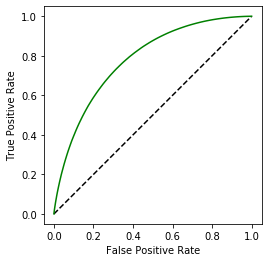

In [53]:
from sklearn.metrics import roc_curve, auc

clf = LogisticRegression(solver='lbfgs',C=1)
#Fit the model on the trainng data.
clf.fit(Xtrain, ytrain)
y_score = clf.predict_proba(Xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot([0,1],[0,1], linestyle='--', color = 'black')
plt.plot(fpr, tpr, color = 'green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')

# XGBoost Model

In [54]:
import sys
!{sys.executable} -m pip install xgboost

In [55]:
from numpy import loadtxt
from xgboost import XGBClassifier

# XGBoost model with hypereparameter tuning

In [56]:
from sklearn.model_selection import RandomizedSearchCV
import time


Xtrain, ytrain, Xtest, ytest = Xtrain, ytrain, Xtest, ytest
clf = XGBClassifier()
param_grid = {

        'silent': [False],

        'max_depth': [6, 10, 15, 20],

        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3]}


randomized_clf = RandomizedSearchCV(clf, param_grid, n_iter=3, n_jobs=1, verbose=2, cv=2,
scoring= 'accuracy', refit=False, random_state=42)
print("Randomized search..")
search_time_start = time.time()
randomized_clf.fit(Xtrain, ytrain)
print("Randomized search time:", time.time() - search_time_start)

best_score = randomized_clf.best_score_
best_params = randomized_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")

for param_name in sorted(best_params.keys()):

    print('%s: %r' % (param_name, best_params[param_name]))

Randomized search..
Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] silent=False, max_depth=6, learning_rate=0.1 ....................
[CV] ..... silent=False, max_depth=6, learning_rate=0.1, total=29.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 29.7min remaining:    0.0s


[CV] silent=False, max_depth=6, learning_rate=0.1 ....................
[CV] ..... silent=False, max_depth=6, learning_rate=0.1, total=26.0min
[CV] silent=False, max_depth=6, learning_rate=0 ......................
[CV] ....... silent=False, max_depth=6, learning_rate=0, total=29.8min
[CV] silent=False, max_depth=6, learning_rate=0 ......................
[CV] ....... silent=False, max_depth=6, learning_rate=0, total=37.0min
[CV] silent=False, max_depth=6, learning_rate=0.001 ..................
[CV] ... silent=False, max_depth=6, learning_rate=0.001, total=32.1min
[CV] silent=False, max_depth=6, learning_rate=0.001 ..................
[CV] ... silent=False, max_depth=6, learning_rate=0.001, total=25.2min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 179.9min finished


Randomized search time: 10800.451380729675
Best score: 0.5678688896880686
Best params: 
learning_rate: 0.1
max_depth: 6
silent: False


In [58]:
model = XGBClassifier(
learning_rate=0.1,
max_depth=6,
silent=False
)

model.fit(Xtrain, ytrain)

[20:42:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, silent=False, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [92]:
y_pred_XB = model.predict(Xtest)

Confusion Matrix:
[[ 772905  210241]
 [  94805 1304506]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.59      0.71    983146
           1       0.77      0.96      0.85   1399311

    accuracy                           0.81   2382457
   macro avg       0.84      0.77      0.78   2382457
weighted avg       0.83      0.81      0.80   2382457

Accuracy: 0.8054596578238348


Precision:              0.77
Recall:                 0.96


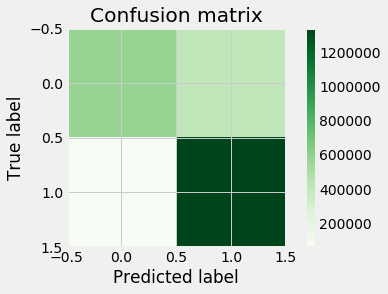

In [93]:
from sklearn.metrics import classification_report
print("Confusion Matrix:")
print(result)
result1 = classification_report(ytest, y_pred_XB)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(ytest,y_pred_XB)
print("Accuracy:",result2)

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = ytest
y_pred_XB = model.predict(Xtest)


conf = confusion_matrix(y_true, y_pred_XB)

print ('\n')
print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))
    
cm=confusion_matrix(y_true, y_pred_XB, labels=[0, 1])
    
plt.figure()
plot_confusion_matrix(cm)

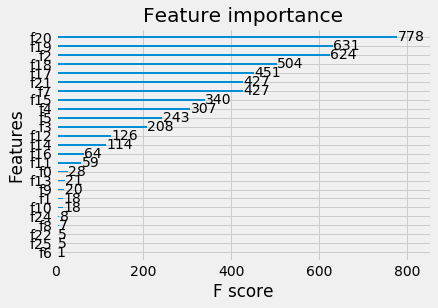

In [94]:
from xgboost import plot_importance
plot_importance(model)

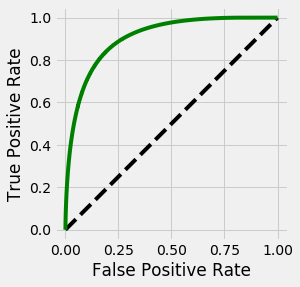

In [95]:
y_score = model.predict_proba(Xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting .
plt.plot([0,1],[0,1], linestyle='--', color = 'black')
plt.plot(fpr, tpr, color = 'green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')

# XGBoost model without parameter tuning

In [61]:
model2 = XGBClassifier()

model2.fit(Xtrain, ytrain)

[22:27:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\gbm\gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [62]:
y_pred = model2.predict(Xtest)
predictions = [round(value) for value in y_pred]

In [64]:
accuracy = accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 78.68%


# Random Forest Model

In [80]:
from sklearn.ensemble import RandomForestClassifier

In [81]:
classifier = RandomForestClassifier(n_estimators = 50)

In [82]:
classifier.fit(Xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [83]:
y_pred = classifier.predict(Xtest)

Confusion Matrix:
[[ 772905  210241]
 [  94805 1304506]]
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84    983146
           1       0.86      0.93      0.90   1399311

    accuracy                           0.87   2382457
   macro avg       0.88      0.86      0.87   2382457
weighted avg       0.87      0.87      0.87   2382457

Accuracy: 0.8719615925911779


Precision:              0.86
Recall:                 0.93


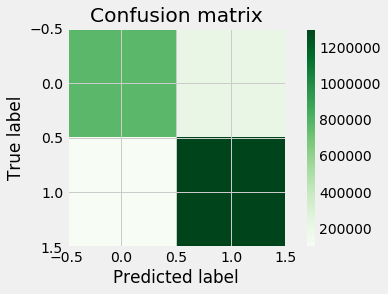

In [84]:
from sklearn.metrics import classification_report
result = confusion_matrix(ytest, y_pred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(ytest, y_pred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(ytest,y_pred)
print("Accuracy:",result2)

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
y_true = ytest
y_pred = classifier.predict(Xtest)


conf = confusion_matrix(y_true, y_pred)

print ('\n')
print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))
    
cm=confusion_matrix(y_true, y_pred, labels=[0, 1])
    
plt.figure()
plot_confusion_matrix(cm)

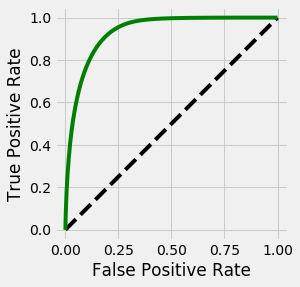

In [85]:
y_score = classifier.predict_proba(Xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1], linestyle='--', color = 'black')
plt.plot(fpr, tpr, color = 'green')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')

Feature ranking:
1. feature 20 (0.141404)
2. feature 2 (0.125195)
3. feature 19 (0.076693)
4. feature 21 (0.059235)
5. feature 5 (0.051846)
6. feature 12 (0.051600)
7. feature 3 (0.047954)
8. feature 17 (0.038987)
9. feature 14 (0.038904)
10. feature 4 (0.036079)
11. feature 18 (0.033749)
12. feature 11 (0.027278)
13. feature 15 (0.027005)
14. feature 16 (0.025094)
15. feature 0 (0.023346)
16. feature 23 (0.020760)
17. feature 7 (0.020507)
18. feature 1 (0.020178)
19. feature 22 (0.019771)
20. feature 10 (0.018930)
21. feature 24 (0.018503)
22. feature 13 (0.018035)
23. feature 25 (0.017912)
24. feature 6 (0.017682)
25. feature 8 (0.013713)
26. feature 9 (0.009640)


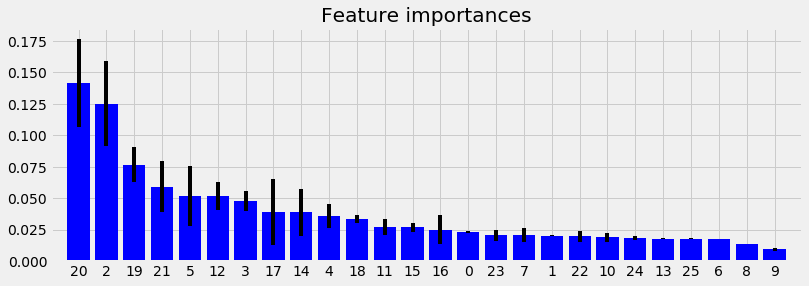

In [104]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(Xtrain.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,4))
plt.title("Feature importances")
plt.bar(range(Xtrain.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

# Constructing a Predicted Shopping cart

In [86]:
cart_prediction = pd.DataFrame({'Actual': ytest.flatten(), 'Predicted': y_pred.flatten()})

In [87]:
Xtest_inverse = scaler.inverse_transform(Xtest)
customer_information = pd.DataFrame(Xtest_inverse)

customer_cart = pd.DataFrame()
customer_cart['order_id'] = customer_information.iloc[:,0].astype(int)
customer_cart['user_id'] = customer_information.iloc[:,1].astype(int)
customer_cart['product_id'] = customer_information.iloc[:,6].astype(int)

customer_cart = pd.merge(customer_cart, products[['product_id','product_name']])
customer_cart.head(2)

,order_id,user_id,product_id,product_name
0,1036038,520,45948,Gluten Free 7 Grain Bread
1,1935491,9431,45948,Gluten Free 7 Grain Bread


In [88]:
customer_cart = pd.concat([customer_cart, cart_prediction], axis = 1)
customer_cart.head(2)

,order_id,user_id,product_id,product_name,Actual,Predicted
0,1036038,520,45948,Gluten Free 7 Grain Bread,0,0
1,1935491,9431,45948,Gluten Free 7 Grain Bread,1,1


In [108]:
customer_sample = customer_cart.user_id == 9431

selected_customer = customer_cart[customer_sample].reset_index()
selected_customer.sort_values(by=['order_id'],ascending=True, inplace=True)
selected_customer.head(10)

,index,order_id,user_id,product_id,product_name,Actual,Predicted
38,605428,130554,9431,21938,Green Bell Pepper,1,1
47,862328,130554,9431,23383,Super Natural Organic Whole Milk,1,1
13,199059,130554,9431,27845,Organic Whole Milk,1,1
25,316163,130554,9431,8518,Organic Red Onion,0,0
80,1791651,130554,9431,36737,Pizza Uncured Pepperoni Gluten Free,0,0
55,929413,130554,9431,30169,Total 2% All Natural Plain Greek Yogurt,1,1
83,1873231,130554,9431,28038,Soft Baked Double Chocolate Brownie Cookies,0,1
62,1306430,130554,9431,42307,Organic Reduced Fat 2% Cottage Cheese,1,1
4,105063,130554,9431,49683,Cucumber Kirby,1,1
50,873788,130554,9431,48679,Organic Garnet Sweet Potato (Yam),1,1
